<a href="https://colab.research.google.com/github/shriver42/ESAA/blob/%ED%95%84%EC%82%AC-%EA%B3%BC%EC%A0%9C/0909_Assignmnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#7. 앙상블 학습과 랜덤 포레스트
결정 트리의 앙상블 : 랜덤 포레스트</br>
배깅,부스팅, 스태킹등 가장 인기 있는 앙상블 방법

##7.1 투표 기반 분류기
각 분류기의 예측을 모아 가장 많이 선택된 클래스를 에측하면 더 좋은 분류기가 만들어진다.</br>
직접 투표 : 다수결 투표로 정해지는 분류기</br>
다수결 투표 분류기는 개별 분류기 중 가장 뛰어난 것보다 정확도가 높을 경우가 많다.</br>
이는 큰 수의 법칙 때문이다

In [1]:
import warnings
warnings.filterwarnings('ignore')

# import package
import numpy as np
import os

#5장에서 소개한 moons dataset 불러오기
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X,y = make_moons(n_samples=100, noise=0.15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [3]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.95
RandomForestClassifier 1.0
SVC 1.0
VotingClassifier 1.0


votingclassifier이 다른 개별 분류기보다 성능이 조금 더 높다.

모든 분류기가 클래스의 확률을 예측할 수 있으면, 개별 분류기의 확률이 가장 높은 클래스를 예측할 수 있다.</br> -> 간접 투표</br>
확률이 높은 투표에 비중을 더 두기에 직접 투표 방식보다 성능이 높다.</br>
voting = 'hard' -> voting = 'soft'로 바꾸어야 하고 모든 분류기가 클래스의 확률을 추정할 수 있으면 된다.

##7.2 배깅과 페이스팅
배깅 : 훈련 세트에서 중복을 허용하여 샘플링 하는 방식</br>
페이스팅 : 중복을 허용하지 않고 샘플링을 하는 방식</br>
배깅과 페이스팅에서는 같은 훈련 샘플을 여러 개의 예측기에 걸처 사용 가능하다.</br>
앙상블의 결과는 원본 데이터셋으로 하나의 예측기를 훈련시킬 때와 비교해 편향은 비슷하지만 분산은 줄어든다.

###7.2.1 사이킷런의 배깅과 페이스팅

In [4]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=50, bootstrap=True, n_jobs=-1)   #배깅 : bootstrap = True / 페이스팅 : False
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

###7.2.2 oob 평가
배깅 테스팅 중 선택되지 않은 훈련 샘플의 나머지를 oob 샘플이라고 부른다.

In [5]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators = 500,
    bootstrap = True, n_jobs = -1, oob_score = True)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9375

In [6]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

1.0

In [7]:
#oob 샘플에 대한 결정 함수의 값
bag_clf.oob_decision_function_

array([[0.        , 1.        ],
       [0.        , 1.        ],
       [0.47089947, 0.52910053],
       [0.13917526, 0.86082474],
       [0.03448276, 0.96551724],
       [0.94857143, 0.05142857],
       [0.98360656, 0.01639344],
       [0.58031088, 0.41968912],
       [0.90607735, 0.09392265],
       [0.68449198, 0.31550802],
       [0.02941176, 0.97058824],
       [0.        , 1.        ],
       [0.87222222, 0.12777778],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.47093023, 0.52906977],
       [0.91411043, 0.08588957],
       [0.9076087 , 0.0923913 ],
       [1.        , 0.        ],
       [0.10497238, 0.89502762],
       [0.9068323 , 0.0931677 ],
       [1.        , 0.        ],
       [0.86390533, 0.13609467],
       [0.19760479, 0.80239521],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.03763441, 0.96236559],
       [0.92893401, 0.07106599],
       [0.93401015, 0.06598985],
       [0.30337079, 0.69662921],
       [1.

##7.3 랜덤 패치와 랜덤 서브스페이스
BaggingClassifier은 특성 샘플링도 지원한다</br>
max_features, bootstrap_features 두 매개 변수로 조절된다.</br>
! 샘플이 아니고 특성에 대한 샘플링이다</br>
랜덤 패치 방식 : 훈련 특성과 샘플을 모두 샘플링 하는 것</br>
랜덤 서브스페이스 방식: 훈련 샘플을 모두 사용하고 특성은 샘플링 하는것</br>
bootstrap = False, max_samples = 1.0 or bootstrap = True, max_samples = less than 1.0

##.7.4 랜덤 포레스트
max_samples를 훈련 세트의 크기로 지정한다.

In [9]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators = 500, max_leaf_nodes=16, n_jobs = -1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

랜덤 포레스트 알고리즘은 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 주입한다.

In [13]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features = "auto", max_leaf_nodes = 16),
    n_estimators = 500, max_samples = 1.0, bootstrap = True, n_jobs = -1)

###7.4.1. 엑스트라 트리
익스트림 랜덤 트리 : 극단적으로 무작위한 트리의 랜덤 포레스트</br>
편향이 늘어나지만 대신 분산을 낮추게 된다.</br>
최적의 임곗값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 다음 그중에서 최상의 분할을 선택한다. </br>일반 랜덤포레스트보다 빠르다.

###7.4.2 특성 중요도
특성의 상대적 중요도를 측정하기 쉽다는 장점이 있다.</br>
가중치 평균이며 각 노드의 가중치는 연관된 훈련 샘플 수의 같다.</br>
사이킷런은 훈련이 끝나고 각 특성마다 자동으로 이 점수를 계싼하고 중요도의 전체 합이 1이 되도록 결관값을 정규화 후 feature_importances 에 저장한다.

In [16]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators = 500, n_jobs = -1)
rnd_clf.fit(iris['data'],iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
  print(name,score)

sepal length (cm) 0.10236017124343949
sepal width (cm) 0.02542866255522984
petal length (cm) 0.4404885646148933
petal width (cm) 0.4317226015864373


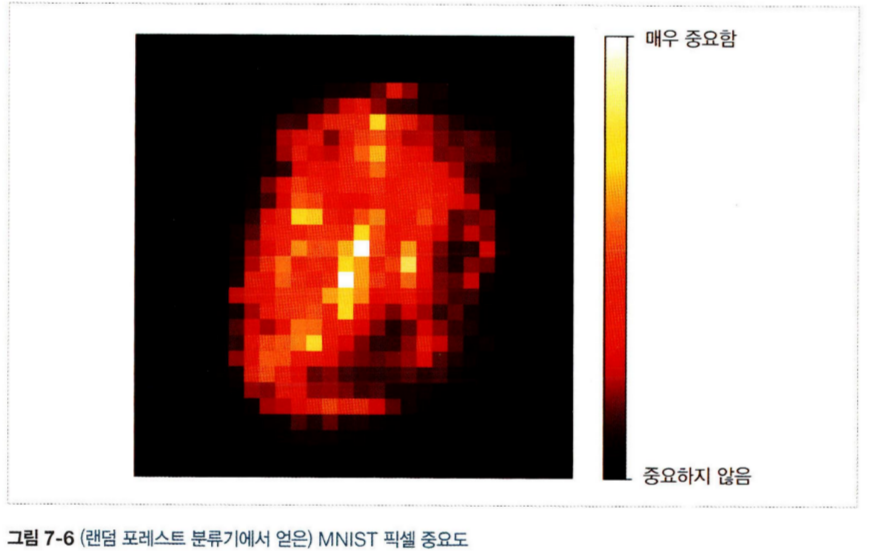

##7.5 부스팅
약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법

###.7.5.1 에이다부스트
이전 예측기를 보완하는 새로운 예측기를 만드는 방법으로 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 것</br>
무작위 예측은 가중치가 0에 가까울 것이며 이보다 나쁘면 가중치는 음수가 된다.</br>
사이킷런은 SAMME 라는 에이다부스트를 사용하며, 에측기가 클래스의 확률 추정이 가능하다면 SAMME.R을 사용한다

In [17]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth = 1), n_estimators = 200,
    algorithm = "SAMME.R", learning_rate = 0.5
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

###7.5.2 그래디언트 부스팅
이전오차를 보정하도록 예측기를 순차적으로 추가한다</br>
에이다부스트와 다르게 이전 예측기가 만든 잔여 오차에 대한 새로운 예측기를 학습시킨다.

In [18]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X,y)
y2 = y-tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(max_depth=2)

In [19]:
y3 = y2-tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=2)

새로운 샘플에 대한 예측은 모든 트리의 예측을 더하면 된다

In [22]:
#y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [24]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth = 2, n_estimators=2, learning_rate = 1.0)
gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=2)

그래디언트 부스팅에서 learning_rate은 매개변수가 각 트리의 기여 정도를 조절</br>
0.1처럼 낮게 설정하면 많은 트리가 필요하지만 예측 성능은 좋아진다.</br> -> '축소' 규제 방법이다. 다만 과대적합을 주의해야 한다

In [25]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X,y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=43)

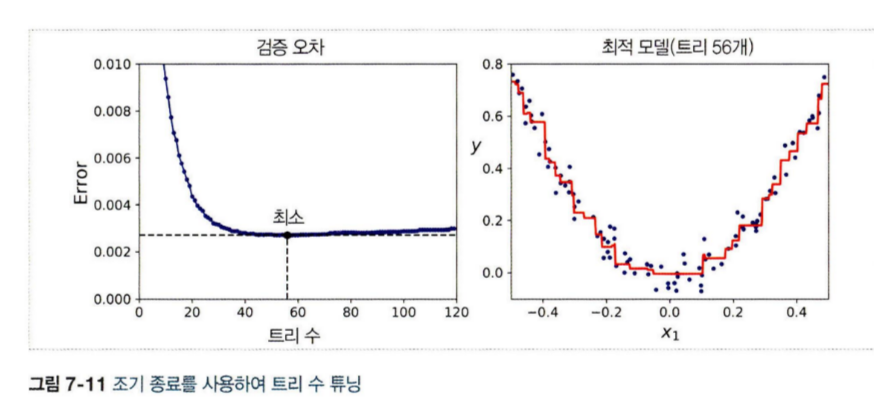

In [28]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float('inf')
error_going_up = 0
for n_estimators in range(1,120):
  gbrt.n_estimators = n_estimators
  gbrt.fit(X_train, y_train)
  y_pred = gbrt.predict(X_val)
  val_error = mean_squared_error(y_val, y_pred)
  if val_error < min_val_error:
    min_val_error = val_error
    error_going_up = 0
  else:
    error_going_up +=1
    if error_going_up == 5:
      break #조기 종료

각 트리가 훈련할 때 사용할 훈련 샘플의 비율도 지정할 수 있는 subsample도 있다.</br>
확률적 그래디언트 부스팅: 일정 비율의 훈련 샘플만 가지고 학습한다. 편향이 높아지는 대신 분산이 낮아지게 된다.

In [29]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train,y_train)
y_pred = xgb_reg.predict(X_val)

##7.6 스태킹
모든 에측기의 예측을 취합하는 대신 취합하는 모델을 훈련시키는 아이디어</br>
사이킷런에서는 스태킹을 직접 지원하지는 않는다

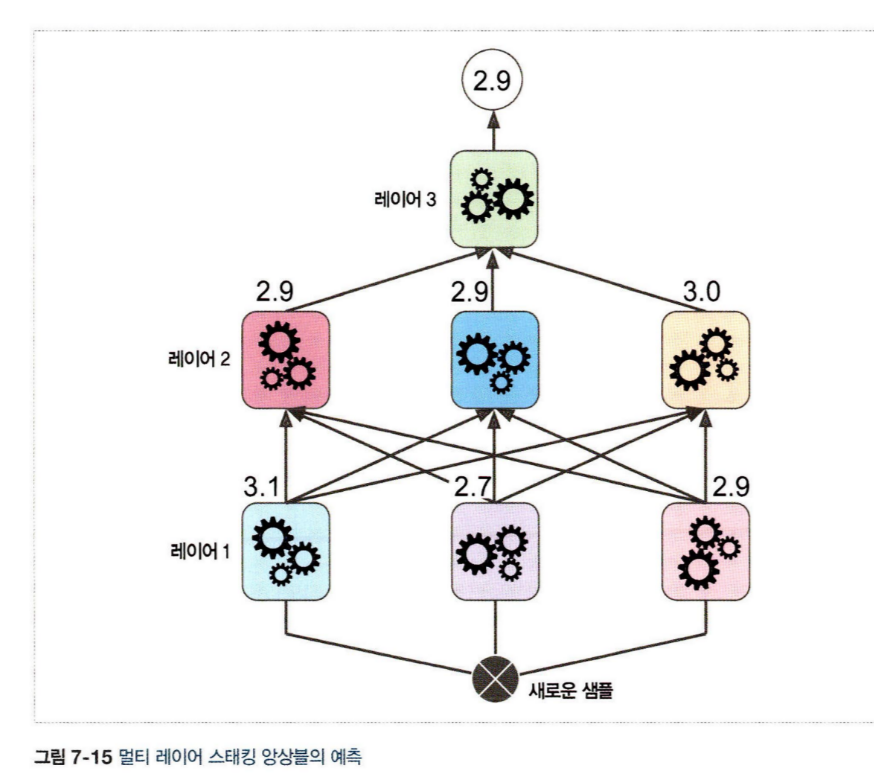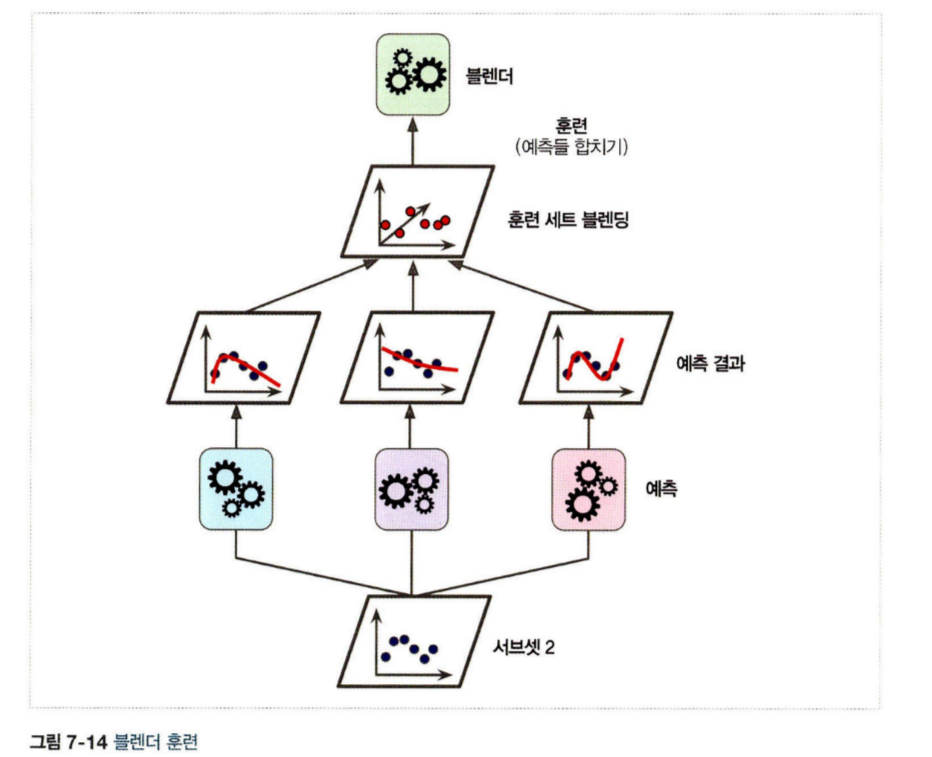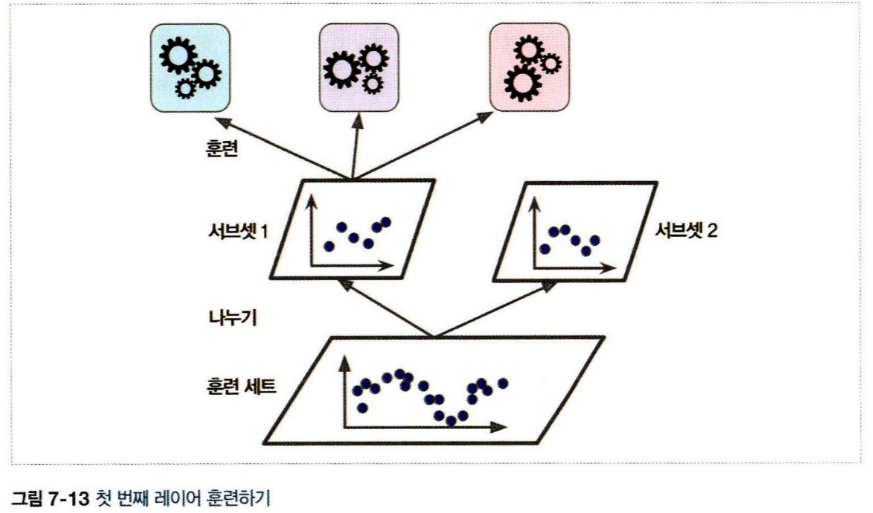